In [2]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git

In [3]:
!nvidia-smi -L

GPU 0: NVIDIA RTX A6000 (UUID: GPU-7de0cdd4-72bc-b63b-c746-81bfbe469d2a)


In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/gpt-j-6b",
    load_in_8bit=True,
    device_map='auto',
)

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6b")
tokenizer.pad_token = tokenizer.eos_token

In [5]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [6]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16, #attention heads
    lora_alpha=32, #alpha scaling
    # target_modules=["q_proj", "v_proj"], #if you know the
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM" # set this for CLM or Seq2Seq
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

In [8]:
from transformers import TextDataset, DataCollatorForLanguageModeling

# Load the datasets
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="train_with_reasoning.csv",
    block_size=256,
)

val_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="val_with_reasoning.csv",
    block_size=256,
)

# Define data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False,
)

/usr/local/lib/python3.9/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (6576023 > 2048). Running this sequence through the model will result in indexing errors


In [9]:
from transformers import Trainer, TrainingArguments

# Define the parameters for fine-tuning
lr = 1e-5
end_lr = 2e-6
num_train_epochs = 1
warmup_steps = 100

trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir='gptj-with-reasoning-results',
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=4,
        warmup_steps=warmup_steps,
        num_train_epochs=num_train_epochs,
        learning_rate=lr,
        weight_decay=0.1,
        fp16=True,
        logging_steps=10,
        logging_dir='./logs',
        evaluation_strategy="steps",
        eval_steps=50,
        
    ),
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)
model.config.use_cache = False

In [10]:
trainer.train()
trainer.save_model()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/usr/local/lib/python3.9/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss
50,2.121100,2.118749
100,2.049500,2.041663
150,1.917400,1.908586
200,1.817600,1.815392
250,1.730000,1.755741
300,1.705000,1.724064
350,1.693100,1.703592
400,1.669900,1.688870
450,1.669300,1.678436
500,1.629300,1.670868


/usr/local/lib/python3.9/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [12]:
model.push_to_hub("harsha28/gptj-lfqa-with-reasoning",
                  use_auth_token=True,
                  commit_message="lr 1e-5, 1 epoch",
                  private=True)

adapter_model.bin:   0%|          | 0.00/29.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/harsha28/gptj-lfqa-with-reasoning/commit/f247d157f68dccb195bff389d1ce7f7b13ec4ff6', commit_message='lr 1e-5, 1 epoch', commit_description='', oid='f247d157f68dccb195bff389d1ce7f7b13ec4ff6', pr_url=None, pr_revision=None, pr_num=None)

In [13]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = "harsha28/gptj-lfqa-with-reasoning"
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_8bit=True, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6b")

# Load the Lora model
model = PeftModel.from_pretrained(model, peft_model_id)


In [37]:
batch = tokenizer("context: Stat. § 14-32.1(a), does not make the definition an essential element of the crime pursuant to N.C. Gen. Stat. § 14-32.1(e). Therefore, we reject Defendant’s argument that it is not sufficient for the indictment to “merely state that the victim was ‘handicapped.’ ” Furthermore, the indictment provided Defendant with enough information to prepare a defense for the offense of felony assault on a handicapped person. See Leonard, _ N.C. App. at _, 711 S.E.2d at 873 (rejecting the defendant’s argument that the indictment was not sufficient because the indictment tracked the relevant language of the statute, listed “the essential elements of the offense[,]” and provided the defendant “with enough information to prepare a defense”); State v. Crisp, 126 N.C. App. 30, 36, 483 S.E.2d 462, 466 (<HOLDING>), appeal dismissed and disc. review denied, 346. question: Is it necessary for the definition of the crime to be stated in the indictment according to N.C. Gen. Stat. § 14-32.1(a)? issues: ", return_tensors='pt')

with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, max_new_tokens=200)

print('\n\n', tokenizer.decode(output_tokens[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




 context: Stat. § 14-32.1(a), does not make the definition an essential element of the crime pursuant to N.C. Gen. Stat. § 14-32.1(e). Therefore, we reject Defendant’s argument that it is not sufficient for the indictment to “merely state that the victim was ‘handicapped.’ ” Furthermore, the indictment provided Defendant with enough information to prepare a defense for the offense of felony assault on a handicapped person. See Leonard, _ N.C. App. at _, 711 S.E.2d at 873 (rejecting the defendant’s argument that the indictment was not sufficient because the indictment tracked the relevant language of the statute, listed “the essential elements of the offense[,]” and provided the defendant “with enough information to prepare a defense”); State v. Crisp, 126 N.C. App. 30, 36, 483 S.E.2d 462, 466 (<HOLDING>), appeal dismissed and disc. review denied, 346. question: Is it necessary for the definition of the crime to be stated in the indictment according to N.C. Gen. Stat. § 14-32.1(a)? is

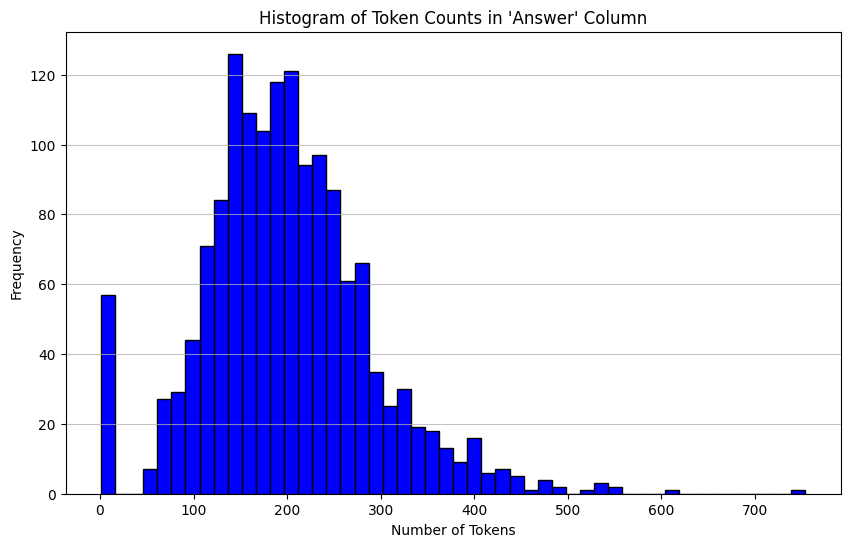

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a tokenizer function called "tokenizer"
# def tokenizer(text):
#     return text.split()  # example tokenizer that splits by spaces

# Load the CSV file
df = pd.read_csv('data/lfqa/test_reasoning.csv')

# Select the 'Answer' column
answers = df['expected_output']

# Calculate the number of tokens in each row
token_counts = answers.apply(lambda x: len(tokenizer.encode(str(x))))

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(token_counts, bins=50, color='blue', edgecolor='black')
plt.title("Histogram of Token Counts in 'Answer' Column")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

In [34]:
for answer in answers:
    print(len(tokenizer.encode(str(answer))))

226
199
234
105
351
148
754
88
119
1
194
1
108
103
135
185
113
207
210
146
268
256
268
235
199
142
198
143
291
234
177
182
191
303
260
214
111
136
122
166
149
335
171
183
229
79
276
216
381
249
179
244
415
311
530
164
244
203
185
265
295
144
123
168
313
126
199
202
212
123
125
213
168
235
144
177
89
129
170
286
185
159
125
248
247
1
373
300
115
211
1
239
210
154
205
129
321
247
185
182
108
1
178
236
230
1
175
224
243
134
313
210
247
1
209
151
267
173
393
230
194
136
139
143
231
67
292
171
208
307
320
182
85
242
188
159
258
185
136
242
605
158
289
273
217
59
92
1
144
68
180
310
225
267
248
343
248
98
225
215
214
367
130
131
118
377
1
237
76
297
292
377
195
276
99
193
230
234
151
209
199
283
187
331
148
127
281
340
209
186
286
135
119
155
1
65
150
170
316
197
284
156
141
270
246
246
273
480
151
554
253
254
192
279
187
245
479
146
426
207
221
197
264
271
1
536
297
247
153
96
129
175
178
186
132
171
158
178
137
176
174
337
166
229
176
231
179
200
444
185
322
220
160
210
86
172
188
240
277


In [23]:
type(answers)

pandas.core.series.Series